# 공부 좀 하겠음.. ㅎㅎ

In [132]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
from datetime import datetime, timedelta
import random as r

def generate_time_series(start_date, num_samples, freq='H'):
    timestamps = pd.date_range(start=start_date, periods=num_samples, freq=freq)
    data1 = np.sin(np.arange(num_samples) * 0.02)  # 예시 데이터 (sin 곡선)
    data2 = np.sin(np.arange(num_samples) * 0.04)  # 예시 데이터 (sin 곡선)
    data3 = np.sin(np.arange(num_samples) * 0.06)  # 예시 데이터 (sin 곡선)
    return pd.DataFrame({'timestamp': timestamps, 'data1': data1, 'data2': data2, 'data3': data3})

# datetime 형식의 타임스탬프를 가진 시계열 데이터 생성
start_date = datetime(2023, 1, 1)
num_samples = 730
freq = 'D'
df = generate_time_series(start_date, num_samples, freq)

# 예시 데이터 생성
data = df
targets = np.array([[np.random.random()] for _ in range(num_samples)])

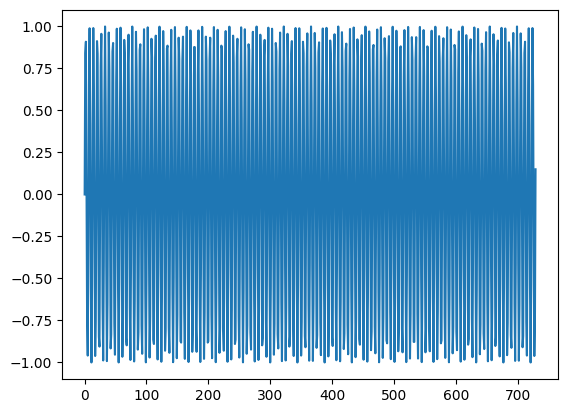

In [110]:
import matplotlib.pyplot as plt

plt.plot(targets)

In [111]:
targets.shape

(730,)

In [112]:
# sequence_length: 각 시퀀스의 길이
# targets: 예측하려는 시퀀스의 다음 값을 나타내는 데이터
# length: 각 시퀀스의 길이
# batch_size: 생성된 시퀀스 배치의 수 

In [133]:
# TimeSeriesGenerator 생성
sequence_length = 30  # 시퀀스 길이 (1개월)
batch_size = 16

# 데이터의 시간 순서를 유지하기 위해 정렬
data.sort_values('timestamp', inplace=True)
data.reset_index(drop=True, inplace=True)

train_data = data[['data1', 'data2', 'data3']].values

train_gen = TimeseriesGenerator(train_data, targets, length=sequence_length, batch_size=batch_size)

# 생성된 배치의 크기 출력
print(f"Number of batches: {len(train_gen)}")

Number of batches: 44


In [138]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Embedding

class TransformerBlock(Model):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TimeSeriesTransformer(Model):
    def __init__(self, num_heads, embed_dim, ff_dim, num_layers):
        super(TimeSeriesTransformer, self).__init__()
        self.embed = Dense(embed_dim)
        self.transformer_blocks = [
            TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)
        ]
        self.final_layer = Dense(1)  # 3개의 출력, 각 특성에 대해 하나씩

    def call(self, inputs):
        x = self.embed(inputs)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        return self.final_layer(x)

# 모델 초기화
embed_dim = 64  # 임베딩 차원
num_heads = 4  # 어텐션 헤드 수
ff_dim = 64  # 피드 포워드 네트워크 차원
num_layers = 3  # Transformer 블록 수

model = TimeSeriesTransformer(num_heads, embed_dim, ff_dim, num_layers)
model.compile(optimizer='adam', loss=MeanSquaredError())
model.build(input_shape=(None, sequence_length, 3))
model.summary()

# 모델 학습
history = model.fit(train_gen, epochs=100, verbose=1)


Model: "time_series_transformer_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            multiple                  256       
                                                                 
 transformer_block_18 (Trans  multiple                 74944     
 formerBlock)                                                    
                                                                 
 transformer_block_19 (Trans  multiple                 74944     
 formerBlock)                                                    
                                                                 
 transformer_block_20 (Trans  multiple                 74944     
 formerBlock)                                                    
                                                                 
 dense_76 (Dense)            multiple                  65        
                                         

1/1 [==============================] - 0s 90ms/step
(1, 730, 1)
1/1 [==============================] - 0s 71ms/step
(1, 730, 1)
1/1 [==============================] - 0s 70ms/step
(1, 730, 1)
1/1 [==============================] - 0s 75ms/step
(1, 730, 1)
1/1 [==============================] - 0s 67ms/step
(1, 730, 1)
1/1 [==============================] - 0s 72ms/step
(1, 730, 1)
1/1 [==============================] - 0s 70ms/step
(1, 730, 1)
1/1 [==============================] - 0s 72ms/step
(1, 730, 1)
1/1 [==============================] - 0s 72ms/step
(1, 730, 1)
1/1 [==============================] - 0s 71ms/step
(1, 730, 1)
1/1 [==============================] - 0s 63ms/step
(1, 730, 1)
1/1 [==============================] - 0s 70ms/step
(1, 730, 1)
1/1 [==============================] - 0s 70ms/step
(1, 730, 1)
1/1 [==============================] - 0s 65ms/step
(1, 730, 1)
1/1 [==============================] - 0s 68ms/step
(1, 730, 1)
1/1 [==============================] - 0

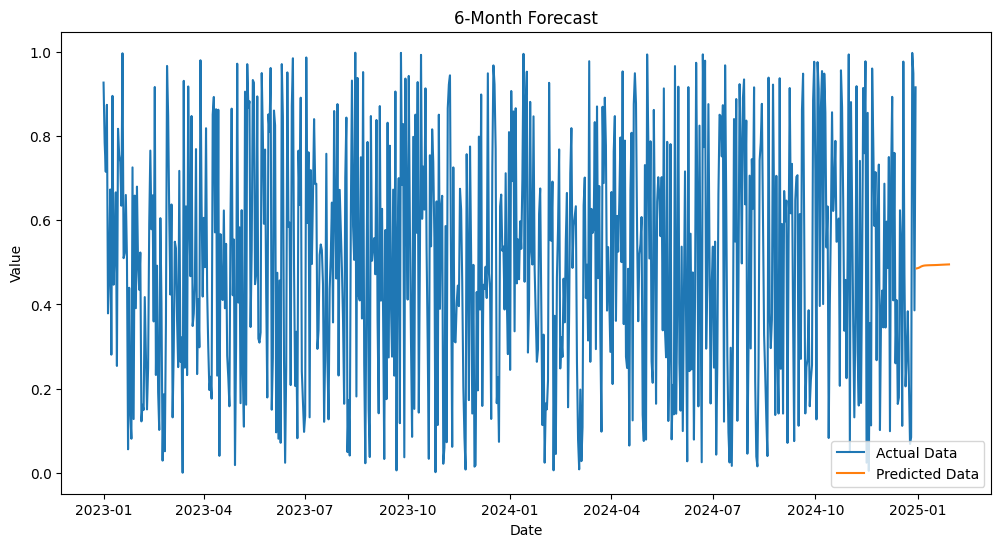

In [153]:
# 미래 6개월 예측 (6개월 = 약 180일)
# future_steps = 180
future_steps = 30 # 180일은 좀 오바인 것 같아서 30일을 예측해봄.
 
# 마지막 입력 시퀀스 가져오기
last_sequence = train_data[-sequence_length:] # sequence length - 30

# 미래 예측 수행
predictions = []
current_sequence = last_sequence

for _ in range(future_steps): 
    current_sequence = current_sequence.reshape((1, sequence_length, 3)) # 1, seq_length, number of columns 
    #reshaped to (1, 30, 3)
    next_value = model.predict(current_sequence) # 모델이 예측을 한다. 
    predictions.append(next_value[0, 0])
    print(next_value.shape)
    next_value_scaled = np.array([next_value[0, 0]] * 3).reshape(1, 1, 3) # next_value를 3개의 동일한 값으로 확장
    current_sequence = np.append(current_sequence[:, 1:, :], next_value_scaled.reshape(1, 1, 3), axis=1) #.reshape(sequence_length, 3)

# 예측 결과 역정규화
# predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# 예측 결과 시각화
import matplotlib.pyplot as plt

future_dates = pd.date_range(df['timestamp'].iloc[-1] + timedelta(days=1), periods=future_steps, freq='D')

plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], targets, label='Actual Data')
plt.plot(future_dates, predictions, label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('6-Month Forecast')
plt.legend()
plt.show()

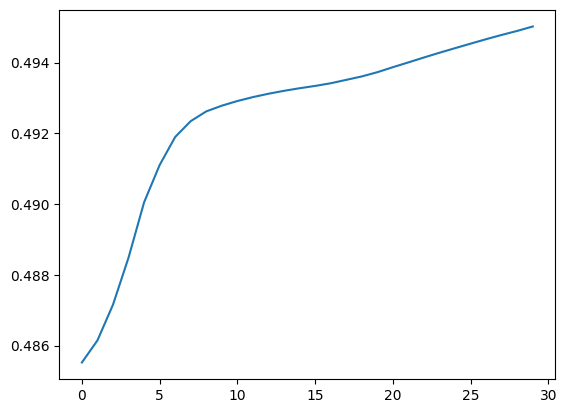

In [154]:
plt.plot(predictions)